### Time Series Forecasting using LSTM and GRU
In this notebook will use LSTM & GRU for predicting the price of stocks of Google for the year 2017

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf

## Helper Functions for Plotting Predictions and Calculating RMSE

In [2]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Google Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Google Stock Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## Getting the data

In [6]:
df = pd.read_csv('/content/GOOGL_2006-01-01_to_2018-01-01.csv',index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


(`*https:`)Slpitting dataset to train set (Before 2017) and test set (2017 and beyond)

In [7]:
training_set = df[:'2016'].iloc[:,1:2].values
test_set = df['2017':].iloc[:,1:2].values

Visualizing the data

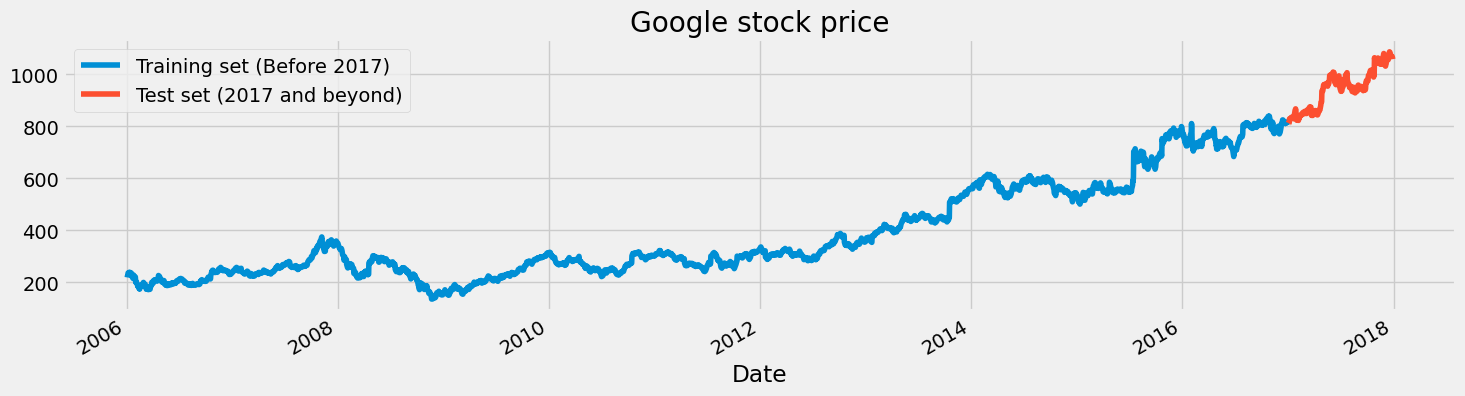

In [9]:
df["High"][:'2016'].plot(figsize=(16,4),legend=True)
df["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Google stock price')
plt.show()

## Data Preprocessing

Scaling the training set

In [10]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output. So for each element of training set, we have 60 previous training set elements

In [11]:
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i-1,0])
X_train, y_train = np.array(X_train), np.array(y_train)

Reshaping X_train for efficient modelling

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## LSTM Model

In [13]:
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
regressor.fit(X_train,y_train,epochs=10,batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - loss: 0.0311
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - loss: 0.0073
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - loss: 0.0047
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - loss: 0.0042
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - loss: 0.0042
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - loss: 0.0032
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - loss: 0.0033
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - loss: 0.0032
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - loss: 0.0025
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - loss: 0.0025



## Make preductuion with LSTM model

In [14]:
dataset_total = pd.concat((df["High"][:'2016'],df["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [15]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


Visualizing the results

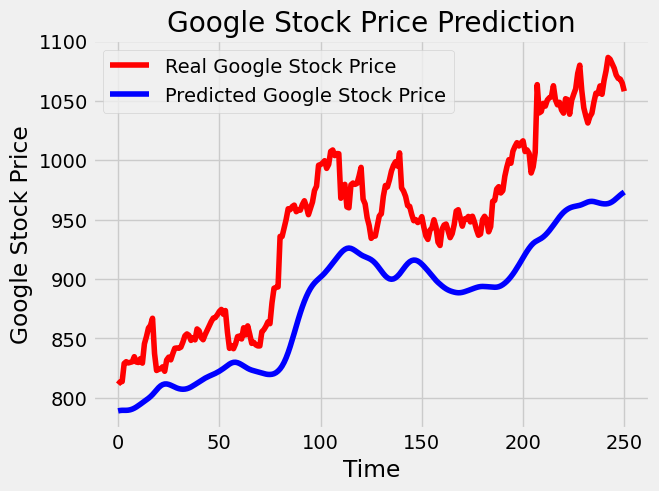

In [16]:
plot_predictions(test_set,predicted_stock_price)

Evaluating LSMT Model

In [17]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 69.83800963380648.


## GRU Model

In [22]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))

In [23]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9
)

In [24]:
regressorGRU.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=False),loss='mean_squared_error')

In [25]:
regressorGRU.fit(X_train,y_train,epochs=30,batch_size=150)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 385ms/step - loss: 0.1152
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - loss: 0.0464
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step - loss: 0.0161
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - loss: 0.0042
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - loss: 0.0033
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - loss: 0.0026
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - loss: 0.0026
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - loss: 0.0028
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - loss: 0.0026
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 385ms/step - loss: 0.0028
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - loss: 0.0023
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - loss: 0.0022
Epoch 13/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - loss: 0.0020
Epoch 14/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - loss: 0.0021
Epoch 15/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/s


## Make preductuion with GRU model

In [26]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step


Visualizing the Results

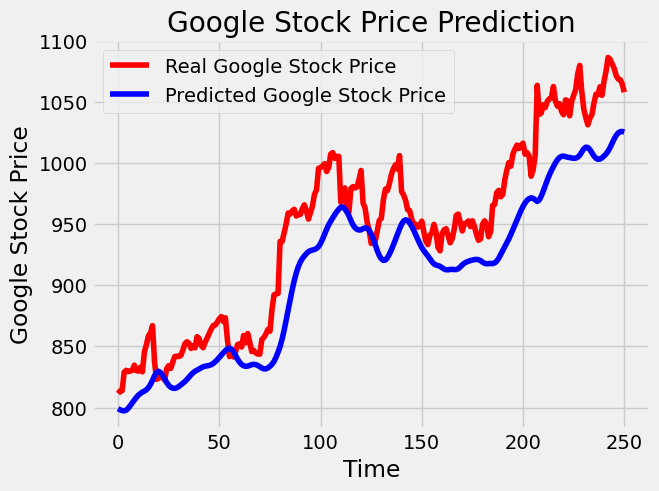

In [27]:
plot_predictions(test_set,GRU_predicted_stock_price)

Evaluating GRU Model

In [28]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 40.02561500574799.
